<a href="https://colab.research.google.com/github/RaihanFazzaufaR/22_RaihanFazzaufaRasendriya/blob/main/Week9_tugas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from google.colab.patches import cv2_imshow
from PIL import Image as im

# Tugas


# Penghapusan Background (Masking)

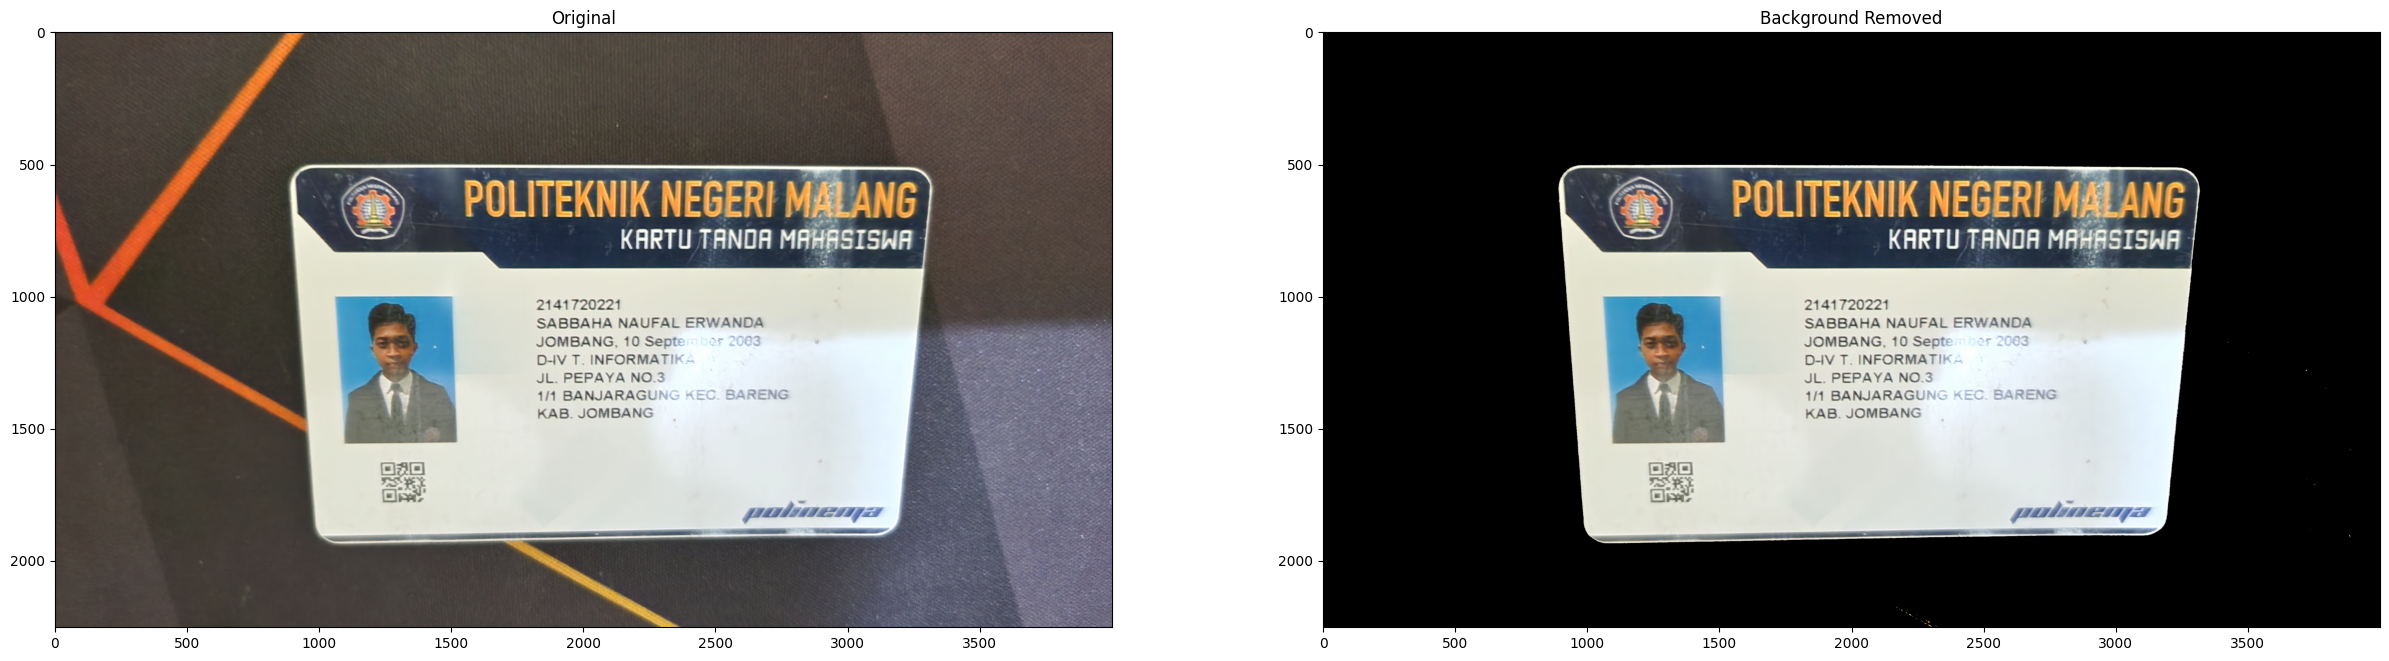

In [86]:
image_original = cv.imread('/content/drive/MyDrive/PCVK/Images/3A_2141720221_4 - Sabbaha Naufal.jpg')
image = cv.cvtColor(image_original, cv.COLOR_BGR2RGB)

gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

_, thresh = cv.threshold(gray, 190, 255, cv.THRESH_BINARY)

contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(image)

cv.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv.FILLED)

img_backgroundremove = cv.bitwise_and(image, mask)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(img_backgroundremove)
plt.title("Background Removed")
plt.show()

# Crop Image

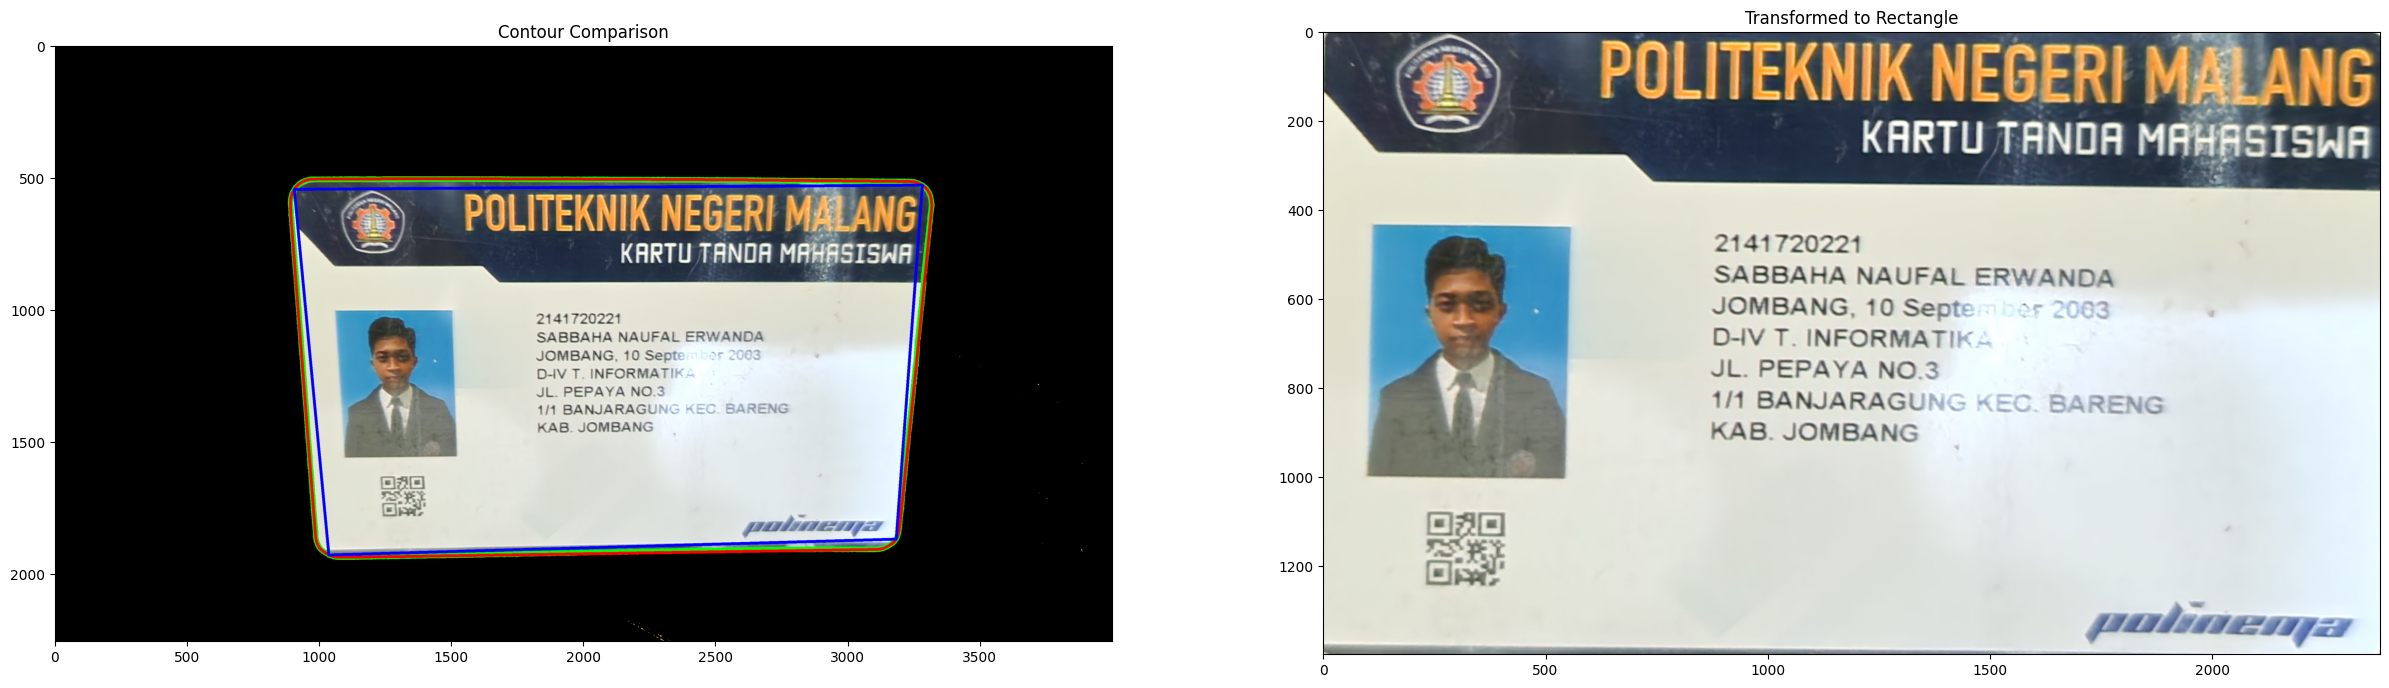

In [87]:
largest_contour = max(contours, key=cv.contourArea)

hull = cv.convexHull(largest_contour)

epsilon = 0.05 * cv.arcLength(hull, True)
approx = cv.approxPolyDP(hull, epsilon, True)

image_with_contours = img_backgroundremove.copy()
cv.drawContours(image_with_contours, [largest_contour], -1, (0, 255, 0), 20)  # Kontur asli (largest)
cv.drawContours(image_with_contours, [hull], -1, (255, 0, 0), 10)  # Kontur cembungan (hull)
cv.drawContours(image_with_contours, [approx], -1, (0, 0, 255), 10)  # Kontur sudut (approx)

if len(approx) == 4:
  trapezium_points = np.array([approx[0][0], approx[1][0], approx[2][0], approx[3][0]], dtype=np.float32)

  x_min = np.min(trapezium_points[:, 0])
  x_max = np.max(trapezium_points[:, 0])
  y_min = np.min(trapezium_points[:, 1])
  y_max = np.max(trapezium_points[:, 1])

  # print(trapezium_points)
  # print(x_min, x_max, y_min, y_max)
  # print(x_max - x_min, y_max - y_min)

  rect_width = int(x_max - x_min)  #2377
  rect_height = int(y_max - y_min) #1400
  rect_points = np.array([[0, 0], [rect_width, 0], [rect_width, rect_height], [0, rect_height]], dtype=np.float32)
  matrix = cv.getPerspectiveTransform(trapezium_points, rect_points)
  warped_img = cv.warpPerspective(img_backgroundremove, matrix, (rect_width, rect_height))

  plt.figure(figsize=(30, 20))

  plt.subplot(1, 2, 1)
  plt.imshow(image_with_contours)
  plt.title("Contour Comparison")

  plt.subplot(1, 2, 2)
  plt.imshow(warped_img)
  plt.title("Transformed to Rectangle")

  plt.show()
else:
  print("Gambar tidak memiliki 4 sudut")

# RGB IMAGE

# Blurr Image (Denoising)

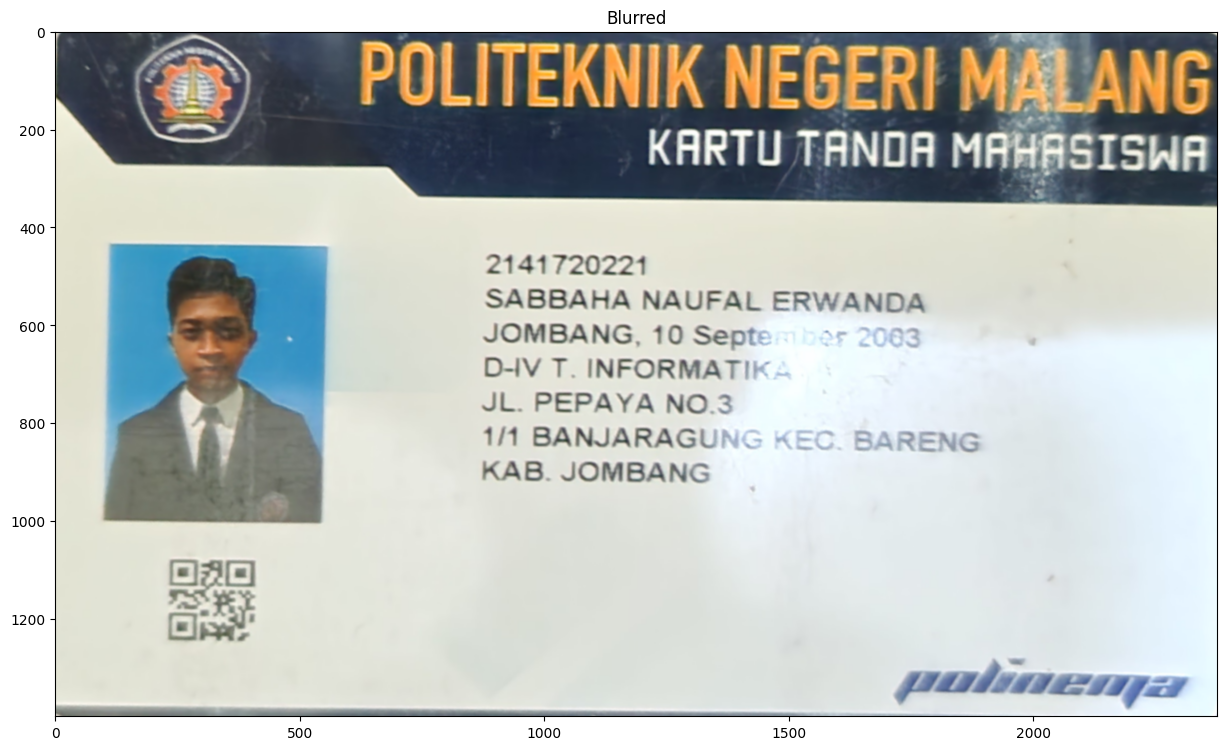

In [88]:
blurred_img = cv.GaussianBlur(warped_img, (5, 5), 0)

plt.figure(figsize=(15, 10))
plt.imshow(blurred_img)
plt.title("Blurred")
plt.show()

# Edge Detection

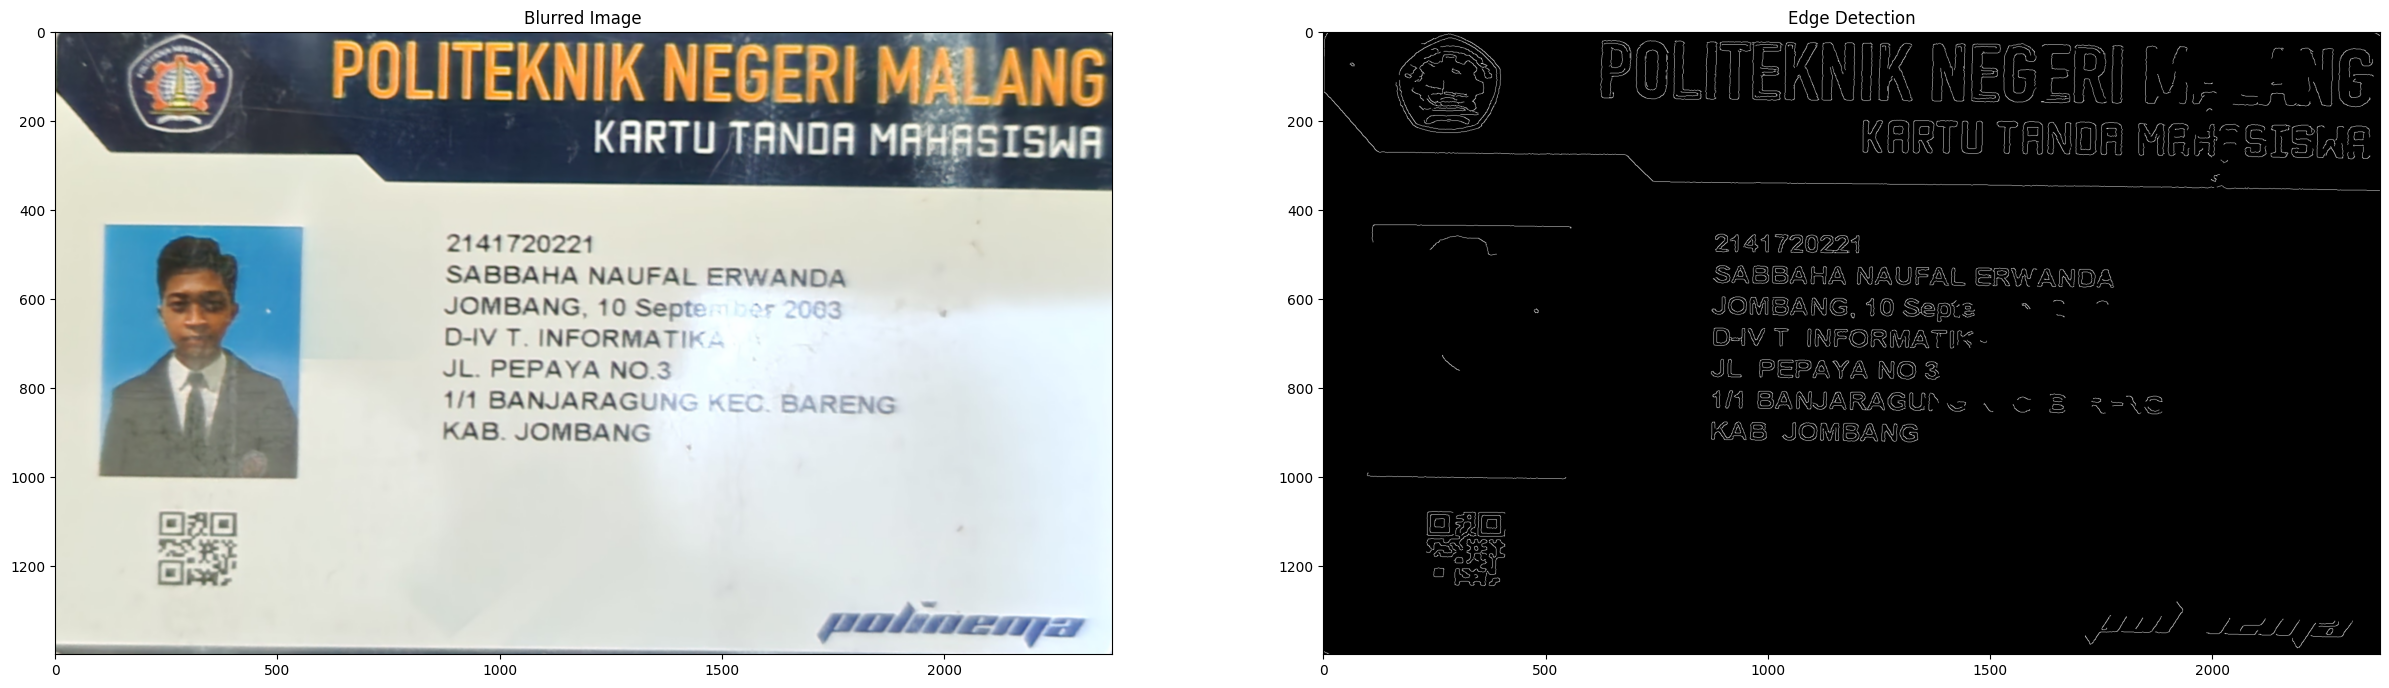

In [89]:
edges_detect = cv.Canny(blurred_img, 100, 200)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(blurred_img)
plt.title("Blurred Image")


plt.subplot(1, 2, 2)
plt.imshow(edges_detect, cmap='gray')
plt.title("Edge Detection")


plt.show()

# Brightness Adjustment

# Histogram Equalization (CLAHE)

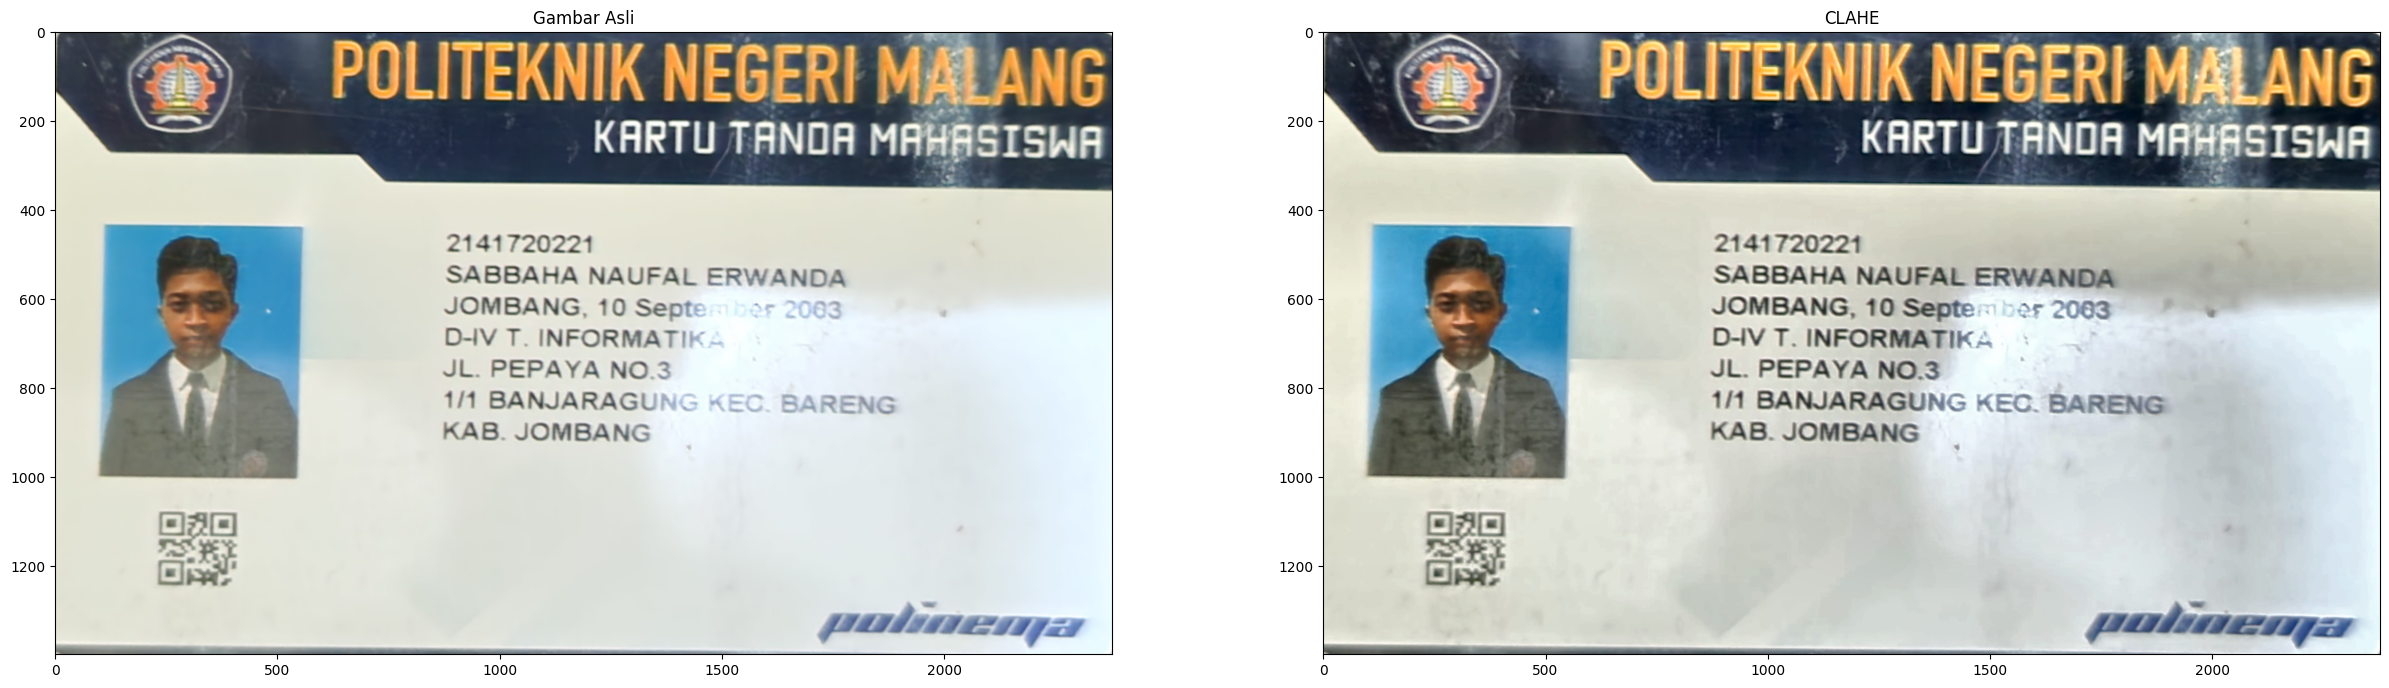

In [90]:
lab = cv.cvtColor(blurred_img.copy(), cv.COLOR_RGB2LAB)
l, a, b = cv.split(lab)

clahe = cv.createCLAHE(clipLimit=2, tileGridSize=(6, 6))
cl = clahe.apply(l)

limg = cv.merge((cl, a, b))

clahe_img = cv.cvtColor(limg, cv.COLOR_LAB2RGB)

plt.figure(figsize=(30, 20))
plt.subplot(1,2,1)
plt.imshow(blurred_img)
plt.title('Gambar Asli')

plt.subplot(1,2,2)
plt.imshow(clahe_img)
plt.title('CLAHE')

plt.show()

# Operasi Aritmatika

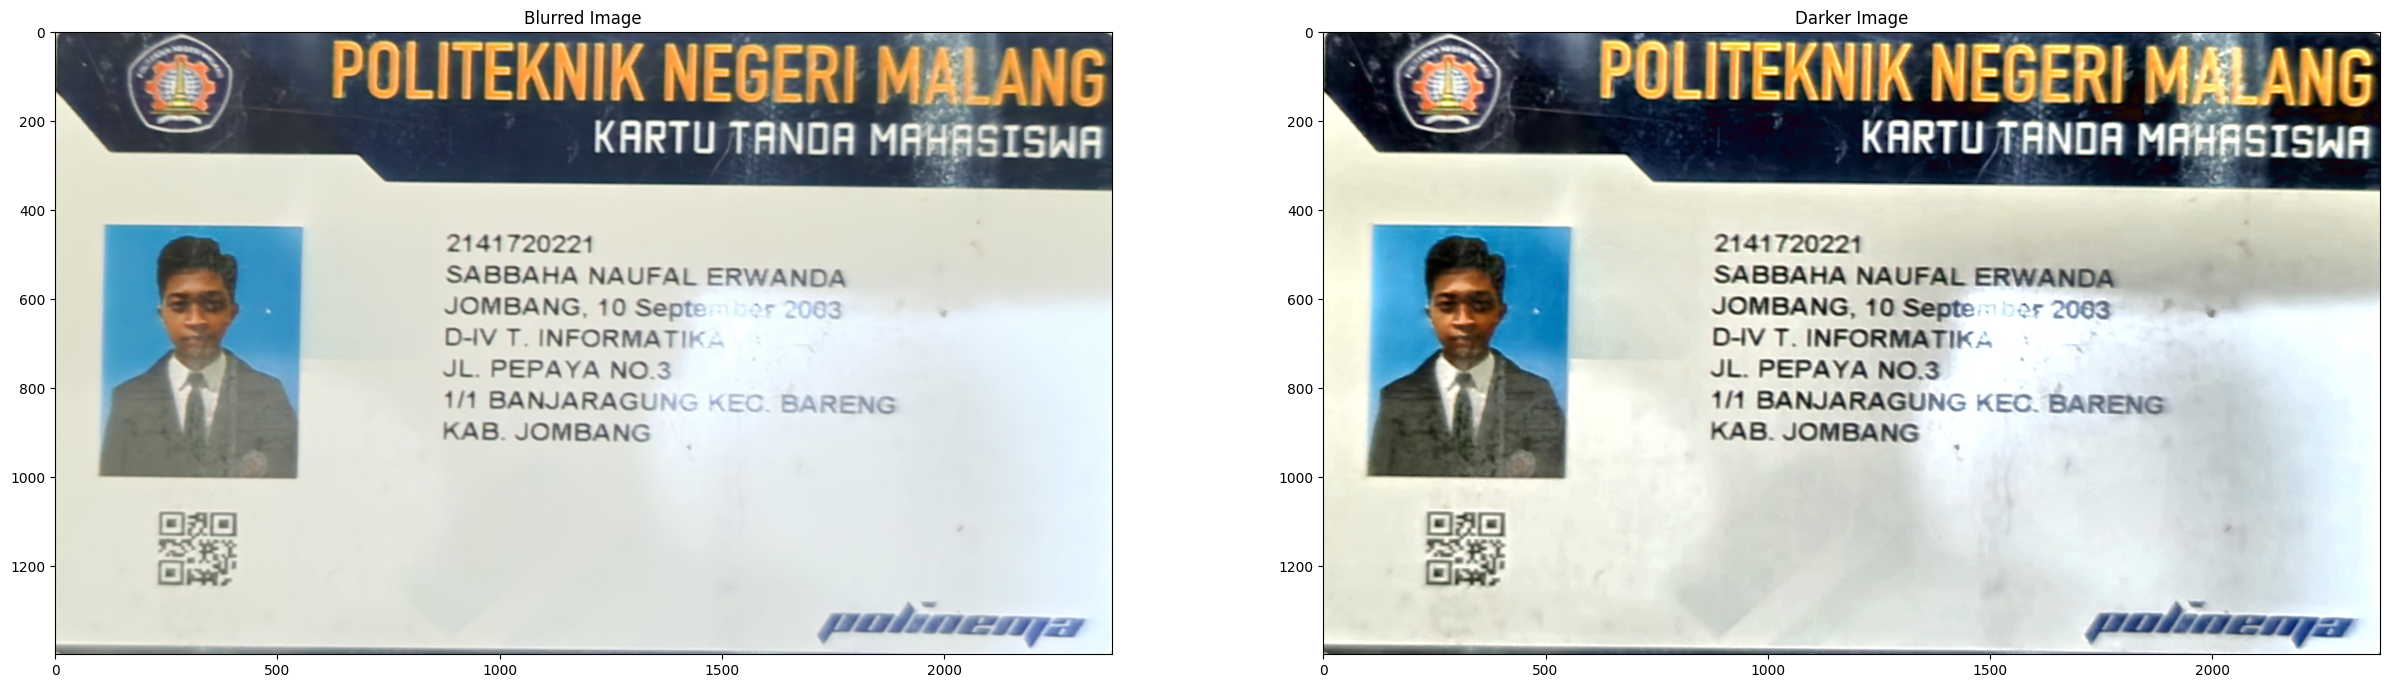

In [91]:
brightness_value = -30
brightness_img = cv.convertScaleAbs(clahe_img, alpha=1.2, beta=brightness_value)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(blurred_img)
plt.title("Blurred Image")

plt.subplot(1, 2, 2)
plt.imshow(brightness_img)
plt.title("Darker Image")
plt.show()

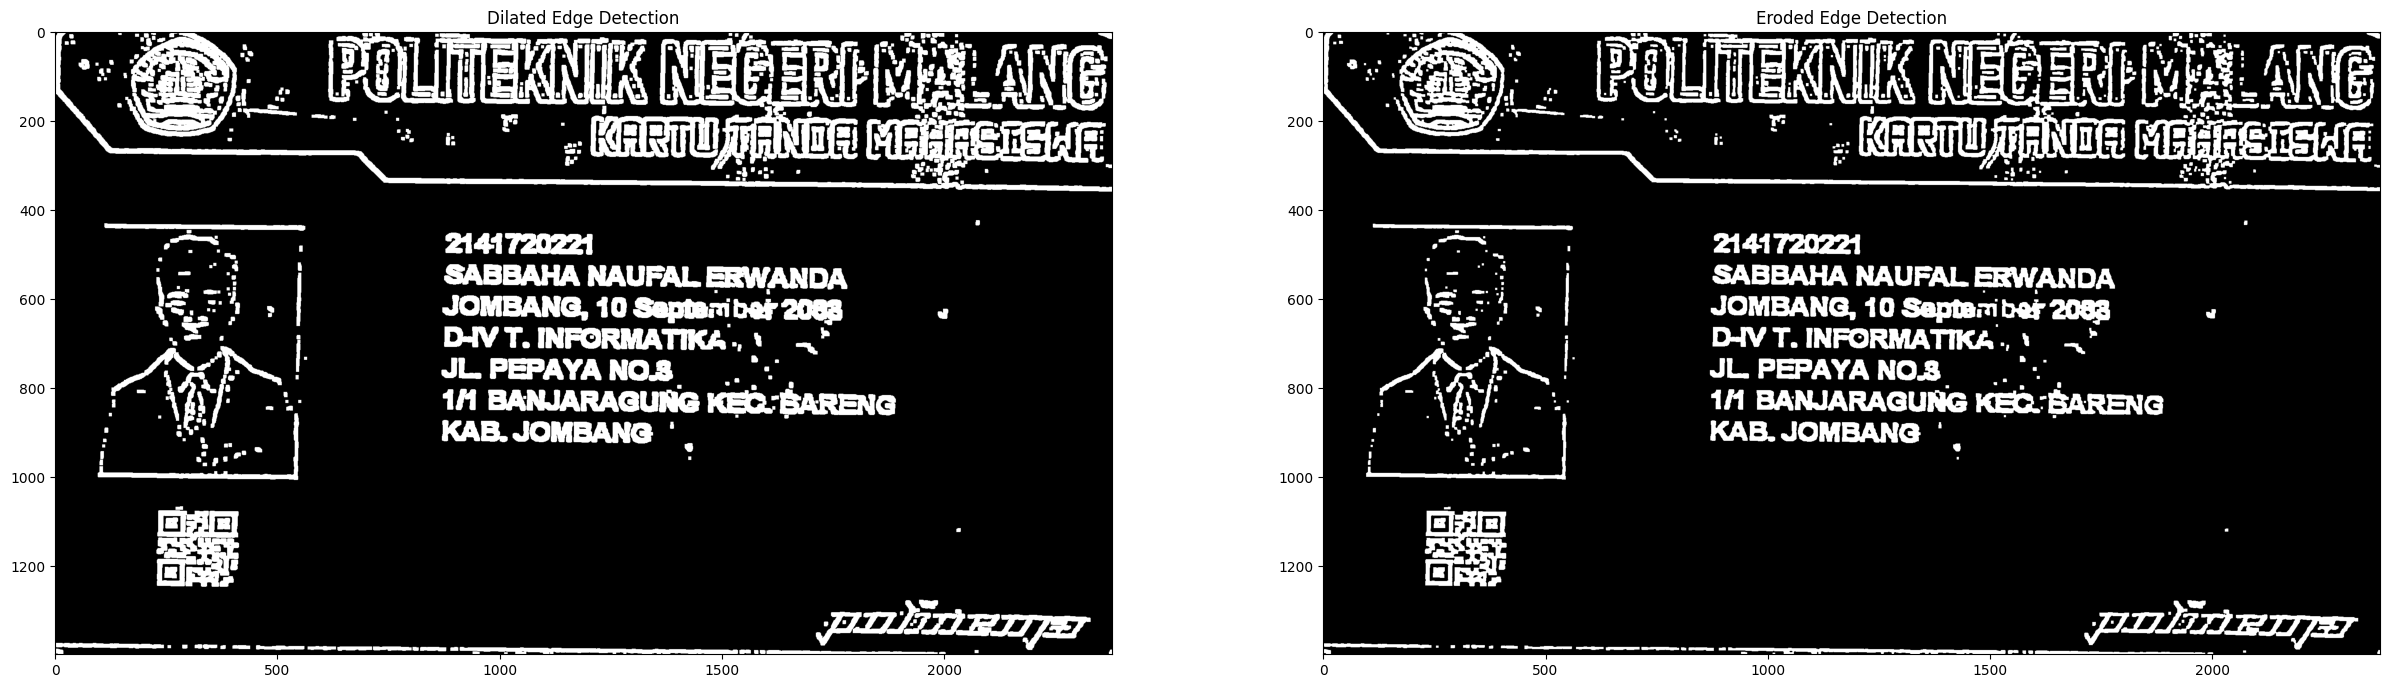

In [98]:
gray_image = cv.cvtColor(clahe_img, cv.COLOR_RGB2GRAY)
adaptive_thresh = cv.adaptiveThreshold(gray_image, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                                        cv.THRESH_BINARY_INV, blockSize=11, C=10)

square = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
cross = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
circle = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))

dilated_img = cv.dilate(adaptive_thresh, square, iterations=3)

eroded_img = cv.erode(dilated_img, cross, iterations=1)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(dilated_img, cmap='gray')
plt.title("Dilated Edge Detection")

plt.subplot(1, 2, 2)
plt.imshow(eroded_img, cmap='gray')
plt.title("Eroded Edge Detection")
plt.show()

In [100]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-ind tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 5,353 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ind all 1:4.00~git30-7274cfa-1.1 [537 kB]
Fetched 5,353 kB in 2s (2,874 kB/s)
debconf: unable to ini

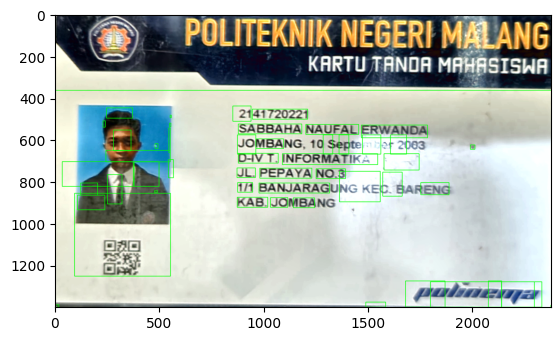

Hasil OCR:
  

Pa | Pa uan
1 i SABBAHA NAUFAL ERWANDA

Ne " | Mal IT KE Ta ala ara ,
Bo AAA Ab RN
Peda aan | JL PEPAYA NO.8
ag NA Ih 1 ANA aan eta tt
ANN AN Ae ET

 

Pon 20an 3 1g.» ah

AG
sg


Blok 1 (Kepercayaan rata-rata: 95.00):
[ '   ' ]

Blok 2 (Kepercayaan rata-rata: 49.11):
[ ' P a ' ,   ' | ' ,   ' P a ' ,   ' u a n ' ,   ' 1 ' ,   ' i ' ,   ' S A B B A H A ' ,   ' N A U F A L ' ,   ' E R W A N D A ' ]

Blok 3 (Kepercayaan rata-rata: 22.06):
[ ' N e ' ,   ' " ' ,   ' | ' ,   ' M a l ' ,   ' I T ' ,   ' K E ' ,   ' T a ' ,   ' a l a ' ,   ' a r a ' ,   ' , ' ,   ' B o ' ,   ' A A A ' ,   ' A b ' ,   ' R N ' ,   ' P e d a ' ,   ' a a n ' ,   ' | ' ,   ' J L ' ,   ' P E P A Y A ' ,   ' N O . 8 ' ,   ' a g ' ,   n a n ,   ' I h ' ,   ' 1 ' ,   ' A N A ' ,   ' a a n ' ,   ' e t a ' ,   ' t t ' ,   ' A N N ' ,   ' A N ' ,   ' A e ' ,   ' E T ' ]

Blok 4 (Kepercayaan rata-rata: 95.00):
[ '   ' ]

Blok 5 (Kepercayaan rata-rata: 7.80):
[ ' P o n ' ,   ' 2 0 a n ' ,   ' 3 ' ,   ' 1 g 

In [116]:
import pytesseract
text_data = pytesseract.image_to_data(eroded_img, output_type='data.frame', lang="ind")
img = brightness_img.copy()

n_boxes = len(text_data['text'])

for i in range(n_boxes):
    if int(text_data['conf'][i] != -1):
        (x, y, w, h) = (text_data['left'][i], text_data['top'][i],
                        text_data['width'][i], text_data['height'][i])
        img = cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(img)
plt.show()

text_string = pytesseract.image_to_string(eroded_img, lang="ind")
print("Hasil OCR:\n", text_string)

filtered_text = text_data[text_data.conf != -1]
lines = filtered_text.groupby('block_num')['text'].apply(list)
confidence = filtered_text.groupby('block_num')['conf'].mean()

for block, texts in lines.items():
    print(f"\nBlok {block} (Kepercayaan rata-rata: {confidence[block]:.2f}):")
    print(" ".join(str(texts)))